# Has Minnesota Delivered on Clean Energy Policies?


My home state of Minnesota touts itself as a leading proponent of climate policy. With clean energy legislation spanning over 20 years, including a 2023 clean energy act that requires utilities to achieve 100% carbon-free energy production by 2040, it would seem that these claims have some legitimacy. However, legislation does not always equate to successful climate policy - for that, we must turn to the data to determine if the state is actually on the right path to deliver these clean energy policies. With that in mind, I ask the question:

***Is Minnesota on the path to achieve its clean energy goals?***

### The Source
All data for this project is queried live from the **U.S. Energy Information Administration** API, available at their website: https://www.eia.gov/.

Information on Minnesota's energy policy comes from the following sources:
- https://www.cleanenergyeconomymn.org/blog/minnesota-policies-support-clean-energy-2020-and-beyond
- https://www.eesi.org/articles/view/minnesota-joins-20-other-states-in-pursuit-of-100-percent-clean-energy
- https://www.revisor.mn.gov/bills/text.php?number=HF7&type=bill&version=2&session=ls93&session_year=2023&session_number=0

In [1]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import requests
import json
from configparser import ConfigParser

In [2]:

parser = ConfigParser()
parser.read('energy.cfg')
apiKey = parser.get('my_api', 'API_KEY')


## MN Energy Policy
We can identify several important landmarks of Minnesota's clean energy policies:

- **2001:** *Minnesota Renewable Energy Objective (REO)* requires utilites to make a good-faith effort to reach 10% renewable energy production by 2015.
- **2007:** *Next Generation Energy Act* requires the state to reduce greenhouse gas emissions by 80% from 2005 to 2050, with benchmarks of a 15% reduction by 2015 and a 30% reduction by 2025.
- **2023:** A new climate bill requires utilities to achieve 80% carbon-free energy by 2030, 90% carbon-free by 2035, and 100% by 2040. Additionally, 55% of all energy sold to MN customers must come from renewable sources by 2035.

These policies provide clear, precise benchmarks for clean energy advancement. In order to determine Minnesota's follow-through on these policies, let's explore the timeline of energy consumption data to determine if the amount of energy being used achieves legislative guidelines.


## Carbon-Free Energy

In [61]:

url = 'https://api.eia.gov/v2/seds/data/?frequency=annual&data[0]=value&facets[stateId][]=MN&facets[seriesId][]=BFTCB&facets[seriesId][]=BMTCB&facets[seriesId][]=GETCB&facets[seriesId][]=HYTCB&facets[seriesId][]=NUETB&facets[seriesId][]=SOTCB&facets[seriesId][]=WYTCB&sort[0][column]=period&sort[0][direction]=desc&offset=0&length=5000'
urlWithKey = url + '&api_key=' + apiKey
response = requests.get(urlWithKey)
response.raise_for_status()
rawJSON = json.loads(response.text)
rawData = rawJSON['response']
consumptionDataRenew = pd.json_normalize(rawData, record_path=['data'])

consumptionDataRenew['valueTrillion'] = consumptionDataRenew['value'] / 1000
consumptionDataRenew['Carbon'] = 'Carbon-free'
groupedConsumptionDataRenew = consumptionDataRenew.groupby(['period', 'seriesId'])
renewData = groupedConsumptionDataRenew.sum('valueTrillion')

url = 'https://api.eia.gov/v2/seds/data/?frequency=annual&data[0]=value&facets[stateId][]=MN&facets[seriesId][]=CLTCB&facets[seriesId][]=NGTCB&facets[seriesId][]=PMTCB&sort[0][column]=period&sort[0][direction]=desc&offset=0&length=5000'
urlWithKey = url + '&api_key=' + apiKey
response = requests.get(urlWithKey)
response.raise_for_status()
rawJSON = json.loads(response.text)
rawData = rawJSON['response']
consumptionDataNonRenew = pd.json_normalize(rawData, record_path=['data'])

consumptionDataNonRenew['valueTrillion'] = consumptionDataNonRenew['value'] / 1000
consumptionDataNonRenew['Carbon'] = 'Non-carbon-free'
groupedConsumptionDataNonRenew = consumptionDataNonRenew.groupby(['period', 'seriesId'])
nonRenewData = groupedConsumptionDataNonRenew.sum('valueTrillion')

consumptionDataCombined = pd.concat([consumptionDataRenew, consumptionDataNonRenew], ignore_index=True)
groupedConsumptionDataCombined = consumptionDataCombined.groupby(['period', 'Carbon'])
combinedData = groupedConsumptionDataCombined.sum('valueTrillion')

groupedConsumptionDataTotal = consumptionDataCombined.groupby('period')
totalData = groupedConsumptionDataTotal.sum('valueTrillion')

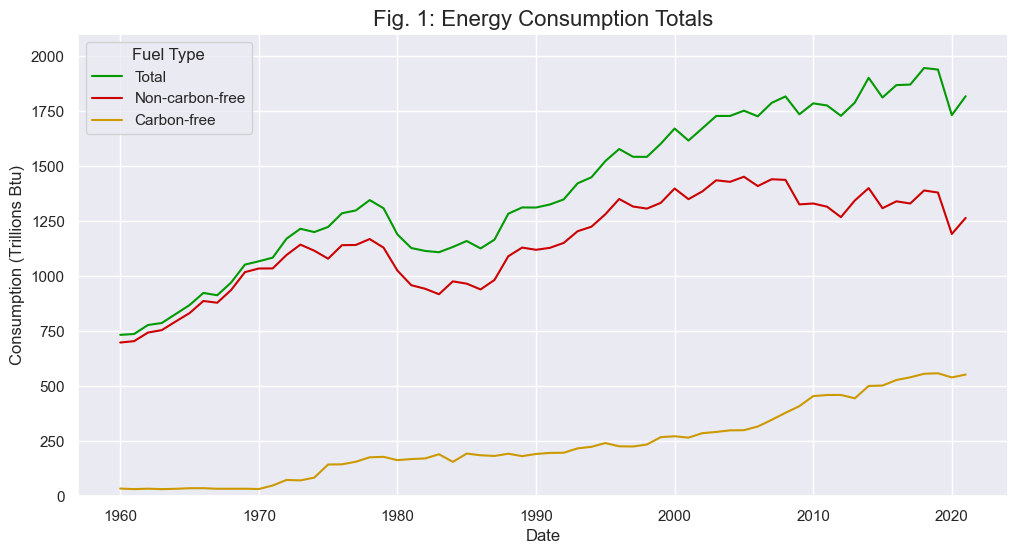

In [62]:

colors = ['#CC0000', '#CC9900', '#009900', '#33CCCC', '#9966FF', '#FF3399']
customPalette = sns.color_palette(colors)
sns.set_theme(style='darkgrid', palette=customPalette)

totalLine = mpl.lines.Line2D([], [], color='#009900',
                          markersize=15, label='Total')

fig, ax = plt.subplots()

sns.lineplot(
    ax=ax, data=combinedData, x='period', y='valueTrillion', hue='Carbon', hue_order=['Non-carbon-free', 'Carbon-free'], errorbar=None
)

sns.lineplot(
    ax=ax, data=totalData, x='period', y='valueTrillion', errorbar=None
)

ax.set_title('Fig. 1: Energy Consumption Totals', fontsize=16)
ax.set_xlabel('Date')
ax.set_ylabel('Consumption (Trillions Btu)')
ax.set_ylim(0, 2100)

children = ax.get_children()
ax.legend(title='Fuel Type', handles=[totalLine, children[0], children[1]], labels=['Total', 'Non-carbon-free', 'Carbon-free'])

fig.set_figwidth(12)
fig.set_figheight(6)


The figure above shows carbon-free and non-carbon-free energy consumption in Minnesota from 1960 to 2021. As shown in Fig 1, carbon-free energy consumption remained relatively low until the early 2000's, with the earliest signs of increase aligning with the Renewable Energy Objective in 2001. We can see that trend continues with further increases in 2007, with the gap between carbon-free and non-carbon-free energy consumption shrinking steadily through 2020.

In 2015, carbon-free energy consumption comprised 27.8% of all consumption in Minnesota. Renewable energy consumption (which excludes biomass and nuclear energy) comprised 11.0% of all consumption. This is on track with the 2001 REO guidelines, which specified 10% renewable energy by the same year. In 2021, carbon-free consumption comprised 30.4% of all consumption, while renewable energy comprised 13.3% of total consumption. Assuming both the rate of increase and total energy consumption remain consistent, the amount of carbon-free consuption will reach about 35.1% in 2030, almost 45 percentage points lower than the goals outlined in the 2023 climate bill. This suggests that drastic measures must be taken in order to achieve the goal of 80% carbon-free energy by 2030, and especially the goal of 100% carbon-free by 2040.

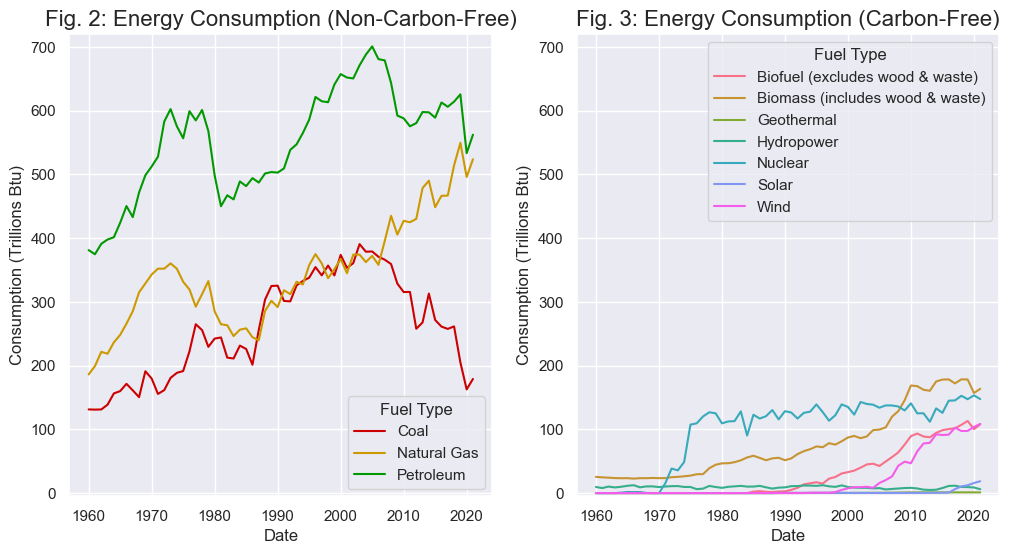

In [64]:

colors = ['#CC0000', '#CC9900', '#009900', '#33CCCC', '#9966FF', '#FF3399']
customPalette = sns.color_palette(colors)
sns.set_theme(style='darkgrid', palette=customPalette)

renewOrder = ['BFTCB', 'BMTCB', 'GETCB', 'HYTCB', 'NUETB', 'SOTCB', 'WYTCB']



fig, (ax1, ax2) = plt.subplots(1, 2)

sns.lineplot(
    ax=ax1, data=nonRenewData, x='period', y='valueTrillion', hue='seriesId', errorbar=None
)

ax1.set_title('Fig. 2: Energy Consumption (Non-Carbon-Free)', fontsize=16)
ax1.set_xlabel('Date')
ax1.set_ylabel('Consumption (Trillions Btu)')
ax1.set_ylim(-5, 720)
ax1.legend(title='Fuel Type', labels=['Coal', 'Natural Gas', 'Petroleum'])

sns.lineplot(
    ax=ax2, data=renewData, x='period', y='valueTrillion', hue='seriesId', hue_order=renewOrder, errorbar=None
)

ax2.set_title('Fig. 3: Energy Consumption (Carbon-Free)', fontsize=16)
ax2.set_xlabel('Date')
ax2.set_ylabel('Consumption (Trillions Btu)')
ax2.set_ylim(-5, 720)
ax2.legend(title='Fuel Type', labels=['Biofuel (excludes wood & waste)', 'Biomass (includes wood & waste)', 'Geothermal', 'Hydropower', 'Nuclear', 'Solar', 'Wind'])

fig.set_figwidth(12)
fig.set_figheight(6)


Fig. 2 and Fig. 3 above break down the energy consumption in Minnesota by fuel type. From Fig. 2 we see that petroleum consistently ranks the highest in consumption, while coal energy consumption decreased dramatically around 2007, likely stemming from the CO2 emission reduction goals from the Next Generation Energy Act. From Fig. 3 we see that nuclear energy and biomass sport the highest consumption of carbon-free energy sources, with wind energy close behind. It is important to note that within the provisions of the 2023 climate bill, biomass and nuclear energy do not qualify as renewable sources for the 2030 goal of 55% renewable energy sold to MN customers.

## Electricity Capabilities of Producers

In [72]:

url = 'https://api.eia.gov/v2/electricity/state-electricity-profiles/capability/data/?frequency=annual&data[0]=capability&facets[stateId][]=MN&facets[energysourceid][]=BAT&facets[energysourceid][]=COL&facets[energysourceid][]=HYC&facets[energysourceid][]=NG&facets[energysourceid][]=NUC&facets[energysourceid][]=OBM&facets[energysourceid][]=OT&facets[energysourceid][]=PET&facets[energysourceid][]=SOL&facets[energysourceid][]=WND&facets[energysourceid][]=WOO&sort[0][column]=period&sort[0][direction]=desc&offset=0&length=5000'
urlWithKey = url + '&api_key=' + apiKey
response = requests.get(urlWithKey)
response.raise_for_status()
rawJSON = json.loads(response.text)
rawData = rawJSON['response']
electricityData = pd.json_normalize(rawData, record_path=['data'])

utilitiesData = electricityData.loc[electricityData['producerTypeDescription'] == 'Electric Utilities']
independentData = electricityData.loc[electricityData['producerTypeDescription'] == 'Independent Power Producers']

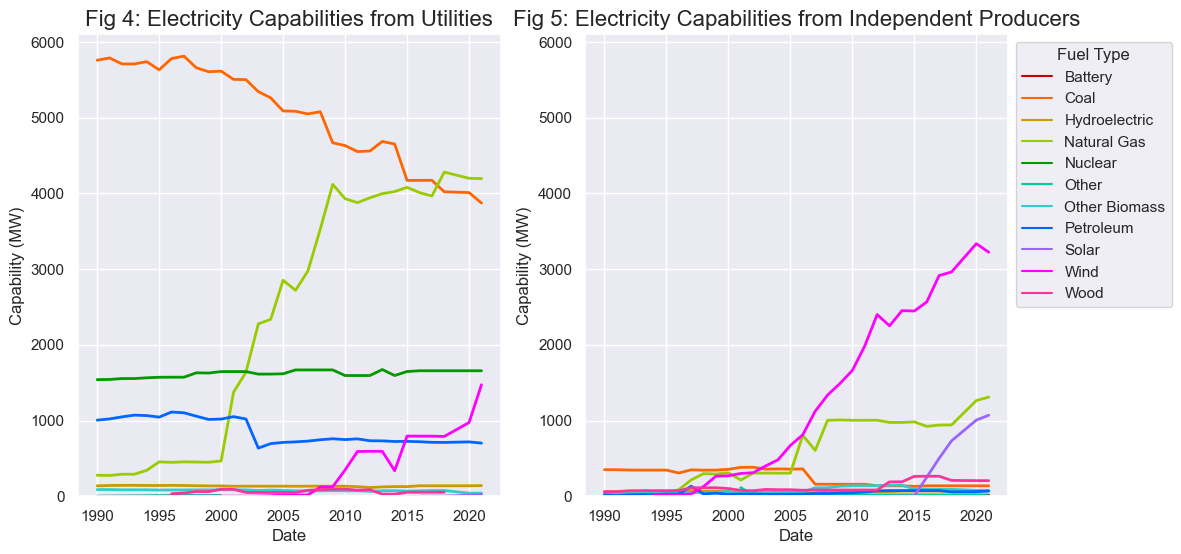

In [69]:

colors = ['#CC0000', '#FF6600', '#CC9900', '#99CC00', '#009900', '#00CC99', '#33CCCC', '#0066FF', '#9966FF', '#FF00FF', '#FF3399']
customPalette = sns.color_palette(colors)
sns.set_theme(style='darkgrid', palette=customPalette)

hueOrder = ['Battery', 'Coal', 'Hydroelectric', 'Natural Gas', 'Nuclear', 'Other', 'Other Biomass', 'Petroleum', 'Solar', 'Wind', 'Wood']

fig, (ax1, ax2) = plt.subplots(1, 2)

sns.lineplot(
    ax=ax1, data=utilitiesData, x='period', y='capability', hue='energySourceDescription', linewidth=2, hue_order=hueOrder
)
ax1.set_title('Fig 4: Electricity Capabilities from Utilities', fontsize=16)
ax1.set_xlabel('Date')
ax1.set_ylabel('Capability (MW)')
ax1.set_ylim(0, 6100)
ax1.set_yticks(np.arange(0, 7) * 1000)
ax1.legend([],[], frameon=False)

sns.lineplot(
    ax=ax2, data=independentData, x='period', y='capability', hue='energySourceDescription', linewidth=2, hue_order=hueOrder
)
ax2.set_title('Fig 5: Electricity Capabilities from Independent Producers', fontsize=16)
ax2.set_xlabel('Date')
ax2.set_ylabel('Capability (MW)')
ax2.set_ylim(0, 6100)
ax2.set_yticks(np.arange(0, 7) * 1000)
ax2.legend(title='Fuel Type')

fig.set_figwidth(12)
fig.set_figheight(6)
sns.move_legend(ax2, "upper left", bbox_to_anchor=(1, 1))


Fig. 4 and Fig. 5 above show the breakdown of generating capacity of electricity producers in MN. We can see from Fig. 4 that utilities using coal and natural gas compose the bulk of energy capabilites in the state, with coal as the primary producer of energy until 2018 until it was replaced by natural gas. Nuclear energy has remained consistent since 1990, with no new nuclear facilites constructed since 1974. We see an increase in wind power among utilities in the past 10 years beginning in 2007, corresponding to the Next Generation Energy Act. Independent energy producers, on the other hand, primarily produce wind power, with natural gas and solar power far behind. We can see the disparity in the capability of independent wind producers and utility wind producers - this suggests that wind farms are more likely to be used on private property than by commercial providers.


## CO2 Emissions

In [81]:

url = 'https://api.eia.gov/v2/co2-emissions/co2-emissions-aggregates/data/?frequency=annual&data[0]=value&facets[stateId][]=MN&facets[sectorId][]=TT&sort[0][column]=period&sort[0][direction]=desc&offset=0&length=5000'
urlWithKey = url + '&api_key=' + apiKey
response = requests.get(urlWithKey)
response.raise_for_status()
rawJSON = json.loads(response.text)
rawData = rawJSON['response']
co2Data = pd.json_normalize(rawData, record_path=['data'])

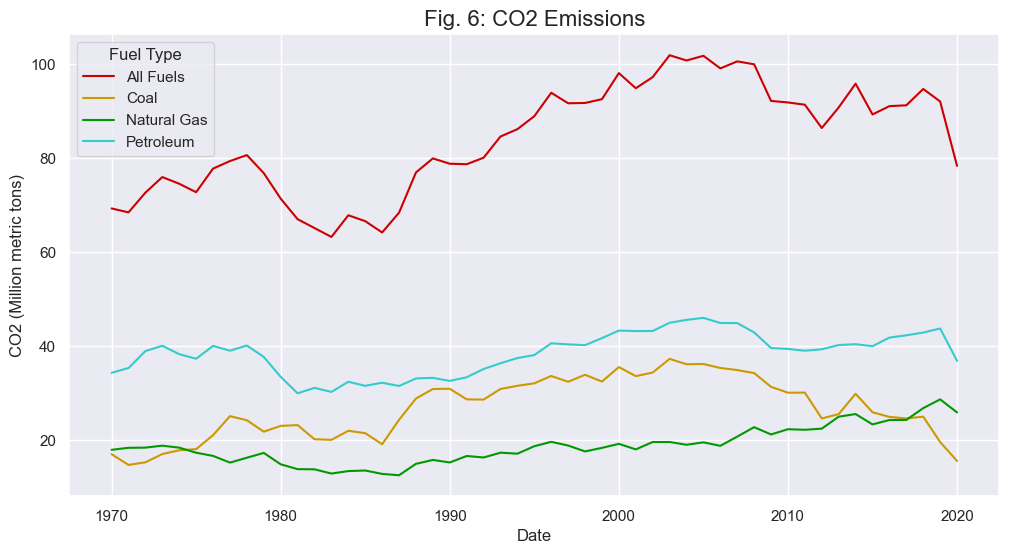

In [79]:

colors = ['#CC0000', '#CC9900', '#009900', '#33CCCC', '#9966FF', '#FF3399']
customPalette = sns.color_palette(colors)
sns.set_theme(style='darkgrid', palette=customPalette)

hueOrder = ['All Fuels', 'Coal', 'Natural Gas', 'Petroleum']

fig, ax = plt.subplots()

sns.lineplot(
    ax=ax, data=co2Data, x='period', y='value', hue='fuel-name', hue_order=hueOrder, errorbar=None
)

ax.set_title('Fig. 6: CO2 Emissions', fontsize=16)
ax.set_xlabel('Date')
ax.set_ylabel('CO2 (Million metric tons)')
ax.legend(title='Fuel Type')

fig.set_figwidth(12)
fig.set_figheight(6)


Fig. 6 shows the gross CO2 emissions broken down by fuel type. We see that emissions from petroleum and natural gas remain relatively consistent, while coal emissions decrease following the 2007 Next Generation Energy Act. From 2005 to 2015, we see a 12% decrease in total emissions, 3 percentage points short of the guidelines in the Next Generation Energy Act. However, from 2005 to 2020, this number nearly doubles, reaching a 23% decrease in total emissions from 2005. Assuming this trend continues, by 2025, we should see a 30% reduction in total emissions from 2005, exactly on schedule for the state's emission goals.


## Conclusions
From these findings, I would conclude that while Minnesota has not accomplished all of its clean energy goals, it has made strides that set move in the right direction to deliver on emission reduction and carbon-free energy output. Emission reductions are on track to continue meeting Next Generation Energy Act guidelines, and while the goals outlined in the 2023 legislation require more drastic measures, Minnesota's improvements in clean energy have a noticeable impact.